In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque

1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.


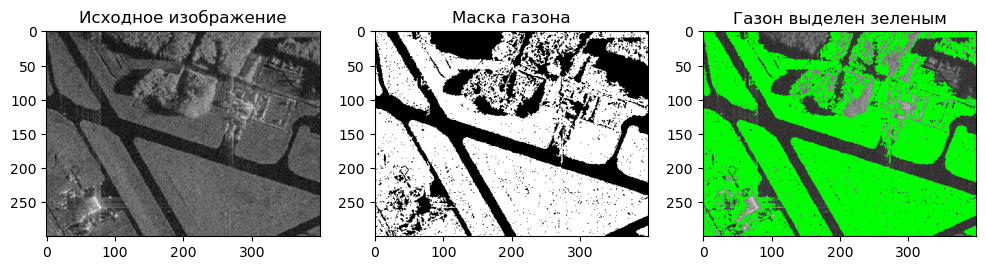


 ОТВЕТ: параметр T = 20


In [2]:
print("1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.")

image = cv2.imread("../data/sar_1.jpg")
if image is None:
    raise FileNotFoundError("Файл sar_1.jpg не найден!")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def homo_average(img, mask, point, T):
    region_vals = img[mask > 0]
    if len(region_vals) == 0:
        return True
    av_val = np.mean(region_vals)
    return abs(av_val - img[point]) <= T


def region_growing(image, seed_point, homo_T, r=1):
    h, w = image.shape
    si, sj = seed_point
    if not (0 <= si < h and 0 <= sj < w):
        raise ValueError(f"seed_point {seed_point} вне изображения")

    mask = np.zeros((h, w), dtype=bool)
    q = deque()
    q.append((si, sj))
    mask[si, sj] = True

    sum_val = float(image[si, sj])
    n_pix = 1
    mean_val = sum_val / n_pix

    offsets = [(di, dj) for di in range(-r, r+1)
                        for dj in range(-r, r+1)
                        if not (di == 0 and dj == 0)]

    while q:
        i, j = q.popleft()

        for di, dj in offsets:
            ni, nj = i + di, j + dj
            if 0 <= ni < h and 0 <= nj < w and not mask[ni, nj]:
                if abs(float(image[ni, nj]) - mean_val) <= homo_T:
                    mask[ni, nj] = True
                    q.append((ni, nj))
                    n_pix += 1
                    sum_val += float(image[ni, nj])
                    mean_val = sum_val / n_pix

    return (mask.astype(np.uint8) * 255)


seed_points = [
    (0, 0),
    (136, 52),
    (0, 35),
    (68, 0),
    (150, 370),
    (140, 310),
    (154, 290),
    (290, 390),
    (120, 0),
    (161, 132)
]

final_mask = np.zeros(gray.shape, np.uint8)
for sp in seed_points:
    mask = region_growing(gray, sp, homo_T=20, r=1)
    final_mask = cv2.bitwise_or(final_mask, mask)

result = image.copy()
result[final_mask > 0] = [0, 255, 0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap="gray")
plt.title("Исходное изображение")

plt.subplot(1, 3, 2)
plt.imshow(final_mask, cmap="gray")
plt.title("Маска газона")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Газон выделен зеленым")

plt.show()

print("\n ОТВЕТ: параметр T = 20")

2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
Критерий: МЕДИАНА
Затравочная точка: (250, 250), r=5, T=20
Итерация 1: добавлено 91 пикселей
Итерация 2: добавлено 257 пикселей
Итерация 3: добавлено 415 пикселей
Итерация 4: добавлено 565 пикселей
Итерация 5: добавлено 733 пикселей
Итерация 6: добавлено 901 пикселей
Итерация 7: добавлено 1044 пикселей
Итерация 8: добавлено 1205 пикселей
Итерация 9: добавлено 1306 пикселей
Итерация 10: добавлено 1054 пикселей
Итерация 11: добавлено 1095 пикселей
Итерация 12: добавлено 1073 пикселей
Итерация 13: добавлено 1015 пикселей
Итерация 14: добавлено 959 пикселей
Итерация 15: добавлено 941 пикселей
Итерация 16: добавлено 861 пикселей
Итерация 17: добавлено 819 пикселей
Итерация 18: добавлено 760 пикселей
Итерация 19: добавлено 695 пикселей
Итерация 20: добавлено 649 пикселей
Итерация 21: добавлено 576 пикселей
Итерация 22: добавлено 538 пикселей
Итерация 23: добавлено 497 пикселей
Итерация 24: доба

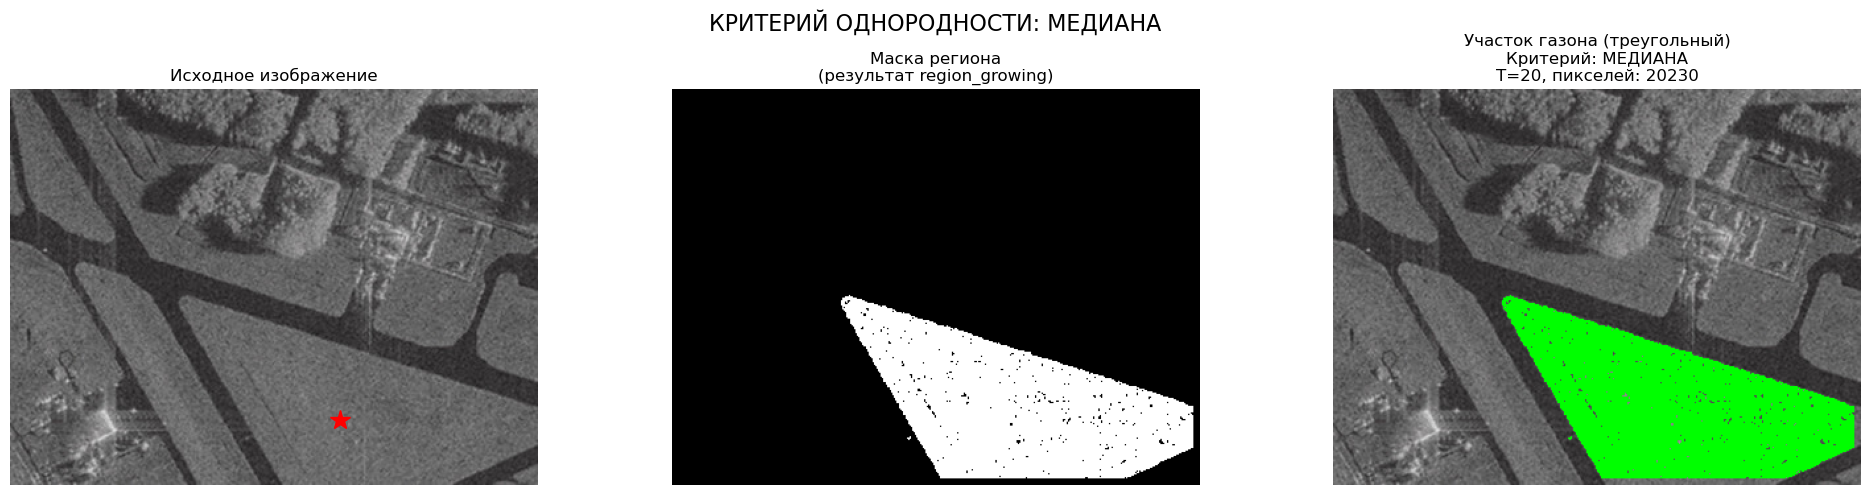


СРАВНИТЕЛЬНАЯ СТАТИСТИКА:
--------------------------------------------------
Критерий 'МЕДИАНА':   20230 пикселей
Площадь региона:     20230 пикселей
Процент от изображения: 16.86%

АНАЛИЗ РЕЗУЛЬТАТОВ:
--------------------------------------------------
Критерий МЕДИАНА:
   - Более точные границы региона
   - Медленнее вычисляется
   - Успешно выделяет треугольный участок газона

ВЫВОД: Алгоритм region_growing с критерием медианы успешно
выделил однородный участок газона треугольной формы.


In [3]:
print("2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.")

image = cv2.imread('../data/sar_1.jpg')
if image is None:
    raise FileNotFoundError("Файл sar_1.jpg не найден!")

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def homo_median(img, mask, point, T):
    region_vals = img[mask > 0]

    med_val = np.median(region_vals)

    return abs(med_val - img[point]) <= T


def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    iteration = 0
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        iteration += 1
        if count > 0:
            print(f"Итерация {iteration}: добавлено {count} пикселей")
        mask += local_mask

    return mask * 255


seed_point = (250, 250)

print("Критерий: МЕДИАНА")
print(f"Затравочная точка: {seed_point}, r=5, T=20")
mask2 = region_growing(image_gray, seed_point, homo_median, 5, 20)

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Исходное изображение')
plt.plot(seed_point[1], seed_point[0], 'r*', markersize=15)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask2, cmap='gray')
plt.title('Маска региона\n(результат region_growing)')
plt.axis('off')

plt.subplot(1, 3, 3)
result2 = image.copy()
result2[mask2 > 0] = [0, 255, 0]
plt.imshow(cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
plt.title(f'Участок газона (треугольный)\nКритерий: МЕДИАНА\nT=20, пикселей: {np.count_nonzero(mask2)}')
plt.axis('off')

plt.suptitle("КРИТЕРИЙ ОДНОРОДНОСТИ: МЕДИАНА", fontsize=16)
plt.tight_layout()
plt.show()

print("\nСРАВНИТЕЛЬНАЯ СТАТИСТИКА:")
print("-" * 50)
print(f"Критерий 'МЕДИАНА':  {np.count_nonzero(mask2):6d} пикселей")
print(f"Площадь региона:     {np.count_nonzero(mask2)} пикселей")
print(f"Процент от изображения: {100 * np.count_nonzero(mask2) / (image_gray.shape[0] * image_gray.shape[1]):.2f}%")

print("\nАНАЛИЗ РЕЗУЛЬТАТОВ:")
print("-" * 50)
print("Критерий МЕДИАНА:")
print("   - Более точные границы региона")
print("   - Медленнее вычисляется")
print("   - Успешно выделяет треугольный участок газона")

print("\nВЫВОД: Алгоритм region_growing с критерием медианы успешно")
print("выделил однородный участок газона треугольной формы.")

Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

РЕЗУЛЬТАТ: Количество найденных деревьев: 100


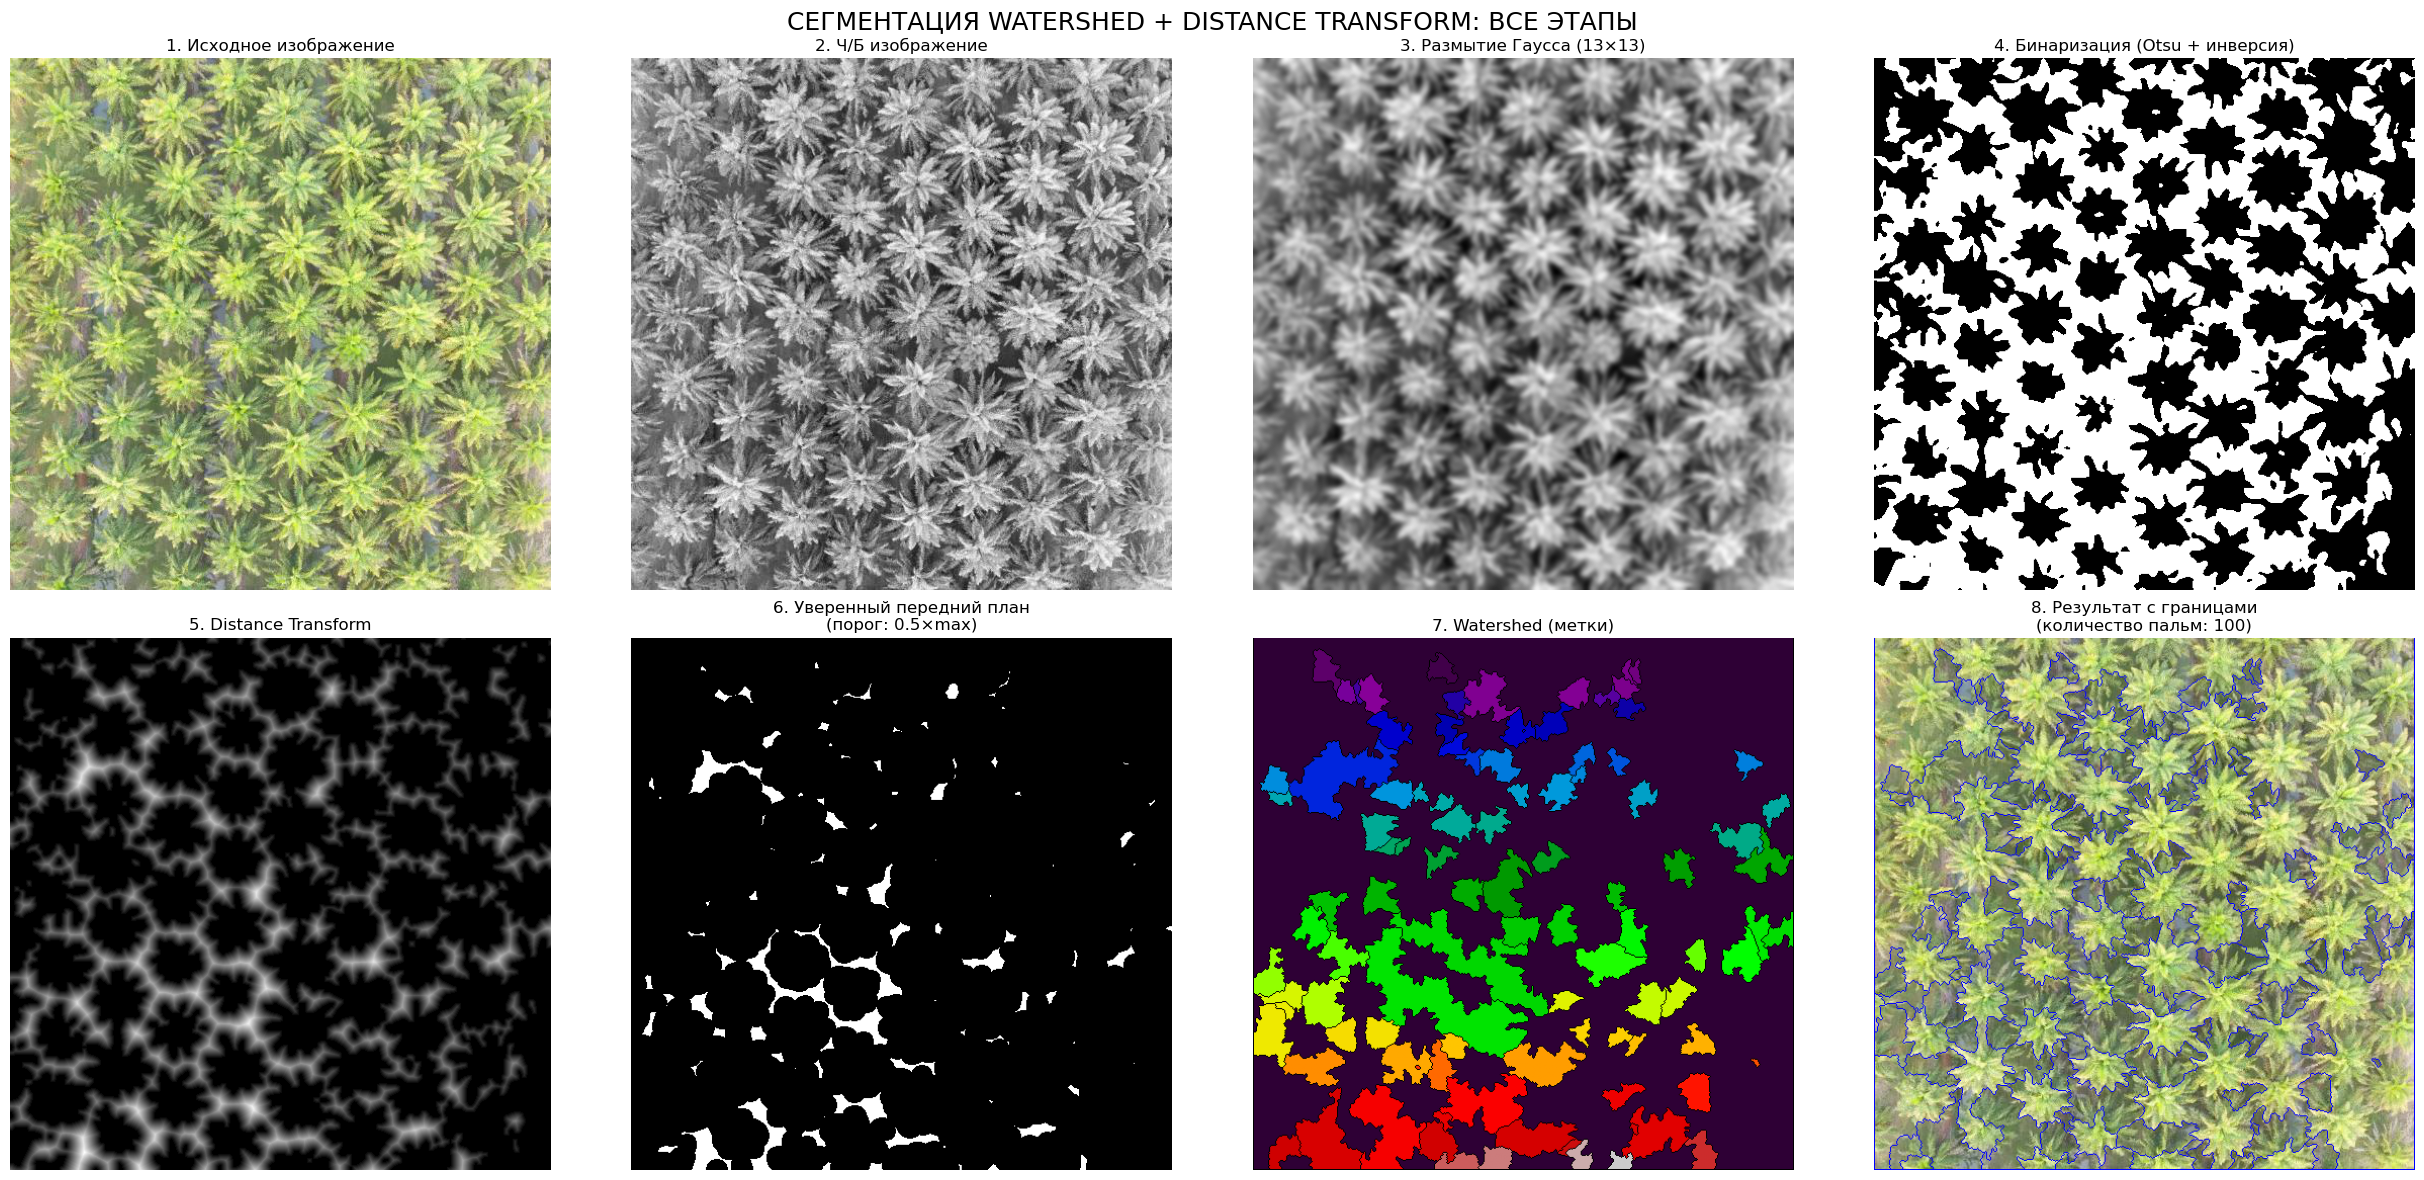

In [4]:
print("Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.")

image_palms = cv2.imread("../data/palm_1.JPG")
if image_palms is None:
    raise FileNotFoundError("Файл palm_1.JPG не найден!")

image_palms_gray = cv2.cvtColor(image_palms, cv2.COLOR_BGR2GRAY)
image_palms_blurred = cv2.GaussianBlur(image_palms_gray, (13, 13), 0)

_, thresh = cv2.threshold(image_palms_blurred, 0, 255,
                          cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

unknown = cv2.subtract(sure_bg, sure_fg)

num_labels, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown == 255] = 0

markers_watershed = cv2.watershed(image_palms, markers.astype(np.int32))

unique_labels = np.unique(markers_watershed)
num_palms = int(np.sum(unique_labels > 1))
print(f"\nРЕЗУЛЬТАТ: Количество найденных деревьев: {num_palms}")

segmented_image = image_palms.copy()
segmented_image[markers_watershed == -1] = [255, 0, 0]

plt.figure(figsize=(25, 12))

plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(image_palms, cv2.COLOR_BGR2RGB))
plt.title("1. Исходное изображение")
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(image_palms_gray, cmap='gray')
plt.title("2. Ч/Б изображение")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(image_palms_blurred, cmap='gray')
plt.title("3. Размытие Гаусса (13×13)")
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(thresh, cmap='gray')
plt.title("4. Бинаризация (Otsu + инверсия)")
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(dist_transform, cmap='gray')
plt.title("5. Distance Transform")
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(sure_fg, cmap='gray')
plt.title("6. Уверенный передний план\n(порог: 0.5×max)")
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(markers_watershed, cmap='nipy_spectral')
plt.title("7. Watershed (метки)")
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title(f'8. Результат с границами\n(количество пальм: {num_palms})')
plt.axis('off')

plt.suptitle("СЕГМЕНТАЦИЯ WATERSHED + DISTANCE TRANSFORM: ВСЕ ЭТАПЫ", fontsize=18)
plt.tight_layout()
plt.show()